# Algoritmos Supervisados: Predicción

En esta sesión seguimos profundizando en las técnicas de Machine Learning.

A lo largo de este cuaderno, usaremos datos de cotización de varias compañias para predecir valores de cierre futuros. Para predecir usaremos una técnica más ``clásica'' como el método [ARIMA](https://es.wikipedia.org/wiki/Modelo_autorregresivo_integrado_de_media_m%C3%B3vil) y, posteriormente, aplicaremos técnicas propias de ML.

Existen númerosos algoritmos supervisados para la predicción de valores, destacamos:

- Linear regressión / Regresión Lineal: https://es.wikipedia.org/wiki/Regresi%C3%B3n_lineal 
- Regresión logística: https://es.wikipedia.org/wiki/Regresi%C3%B3n_log%C3%ADstica
- Máquinas de vectores de soporte / SVM: https://es.wikipedia.org/wiki/M%C3%A1quinas_de_vectores_de_soporte
- CART / Classification And Regression Trees https://www.nature.com/articles/nmeth.4370
- Gradient Boosting / Potenciación del gradiente: https://es.wikipedia.org/wiki/Gradient_boosting
- Random Forest / Bosques aleatorios: https://es.wikipedia.org/wiki/Random_forest
- Artificial Neural Networks (*):  https://en.wikipedia.org/wiki/Artificial_neural_network
- K-vecinos cercanos / K-nearest neighbors (k-nn): https://es.wikipedia.org/wiki/K_vecinos_m%C3%A1s_pr%C3%B3ximos
- Análisis Discriminantel Lineal / LDA: https://es.wikipedia.org/wiki/An%C3%A1lisis_discriminante_lineal
- etc.


La gran mayoría están implementados en la librería de python [scikit-learn/supervised_learning](https://scikit-learn.org/stable/supervised_learning.html)

<img src="images/ModelSelection_ref_book_5.png" width=90%/>

> Fuente de la imagen: [5] Machine Learning & Data Science Blueprints for Finance



In [1]:
%pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Obtención de datos

¡Necesitamos datos! Principalmente, datos con índices de tiempo: **series temporales**.
Por ello, vamos a instalar una librería que nos proporcionará datos públicos ya preparados.


In [2]:
%pip install pandas_datareader
%pip install yfinance



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# código para corregir divergencias entre versiones de la librería pandas_Datareader
import yfinance as yf
yf.pdr_override()

In [12]:
import pandas as pd
from pandas_datareader import data as pdr

data = pdr.get_data_yahoo("GOOGL", start="2017-01-01", end="2020-12-31")

#data = yf.Ticker("GOOGL") #, start="2017-01-01", end="2020-12-31")
print(type(data))
data.to_csv("GOOGL.csv")

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>


In [32]:
print(data) # Python tip: una invocación stk_data.__rep__

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2017-01-03  40.030998  40.571999  39.844501  40.400501  40.400501  39180000
2017-01-04  40.494499  40.671501  40.205502  40.388500  40.388500  30306000
2017-01-05  40.375000  40.687000  40.296001  40.651001  40.651001  26810000
2017-01-06  40.749500  41.448002  40.575001  41.260502  41.260502  40342000
2017-01-09  41.318501  41.521500  41.081001  41.359001  41.359001  28178000
...               ...        ...        ...        ...        ...       ...
2020-12-23  86.196503  87.205498  86.059998  86.411499  86.411499  22974000
2020-12-24  86.449997  87.120499  86.217499  86.708000  86.708000   9312000
2020-12-28  87.245499  89.349998  87.091003  88.697998  88.697998  27650000
2020-12-29  89.361504  89.423500  87.755501  87.888000  87.888000  19726000
2020-12-30  88.250000  88.388000  86.400002  86.812500  86.812500  21026000

[1006 rows 

In [33]:
data.columns # ¿Cómo es el índice de acceso a los datos?

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [34]:
data["Close"] #Hagamos una prueba

Date
2017-01-03    40.400501
2017-01-04    40.388500
2017-01-05    40.651001
2017-01-06    41.260502
2017-01-09    41.359001
                ...    
2020-12-23    86.411499
2020-12-24    86.708000
2020-12-28    88.697998
2020-12-29    87.888000
2020-12-30    86.812500
Name: Close, Length: 1006, dtype: float64

In [35]:
data.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='Date', length=1006, freq=None)

### Análisis de la serie temporal
Existen númerosos indicadores sobre el comportamiento de una serie temporal. 
La [descomposición](https://en.wikipedia.org/wiki/Decomposition_of_time_series) permite tener una idea de su "naturaleza". 
Hay dos tipos de descomposiciones: aditiva o multiplicativa.
- Descomposición aditiva  $Y[t] = T[t] + S[t] + e[t]$ 
- T_{t}, the trend component at time t, which reflects the long-term progression of the series (secular variation). A trend exists when there is a persistent increasing or decreasing direction in the data. The trend component does not have to be linear.
- C_{t}, the cyclical component at time t, which reflects repeated but non-periodic fluctuations. The duration of these fluctuations depend on the nature of the time series.
- S_{t}, the seasonal component at time t, reflecting seasonality (seasonal variation). A seasonal pattern exists when a time series is influenced by seasonal factors. Seasonality occurs over a fixed and known period (e.g., the quarter of the year, the month, or day of the week).[1]
- I_t, the irregular component (or "noise") at time t, which describes random, irregular influences. It represents the residuals or remainder of the time series after the other components have been removed.

Necesitaremos una librería especial para facilitar esta tarea.

In [ ]:
%pip install statsmodels

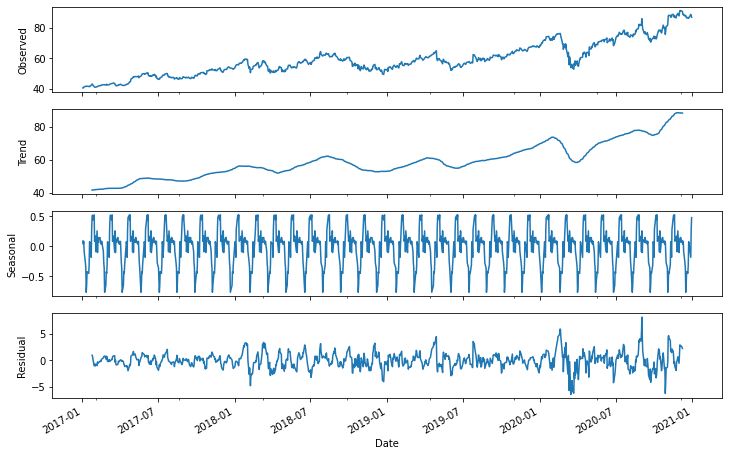

In [37]:
# Paso 1
import matplotlib.pyplot as plt
import statsmodels.api as sm
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

res = sm.tsa.seasonal_decompose(data['Close'],period=30)
#res.plot()

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,8))
res.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
res.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
res.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
res.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

## Predicción con ARIMA

In [40]:
# Podemos trabajar con diferentes periodos para la predicción. 
# Vamos a probar meses
data.index = pd.to_datetime(data.index)
month_index = data.index.to_period('M')
month_index

PeriodIndex(['2017-01', '2017-01', '2017-01', '2017-01', '2017-01', '2017-01',
             '2017-01', '2017-01', '2017-01', '2017-01',
             ...
             '2020-12', '2020-12', '2020-12', '2020-12', '2020-12', '2020-12',
             '2020-12', '2020-12', '2020-12', '2020-12'],
            dtype='period[M]', name='Date', length=1006)

In [41]:
# Paso 2.a  Cargamos/Fit/Entrenamos ARIMA 
from statsmodels.tsa.arima_model import ARIMA
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html
close = data["Close"]
close.index = month_index
print(close.shape)
print(close[-12:])


(1006,)
Date
2020-12    87.612999
2020-12    88.054001
2020-12    87.859497
2020-12    87.025497
2020-12    86.310997
2020-12    86.727997
2020-12    86.011002
2020-12    86.411499
2020-12    86.708000
2020-12    88.697998
2020-12    87.888000
2020-12    86.812500
Freq: M, Name: Close, dtype: float64


In [42]:
mod = sm.tsa.arima.ARIMA(endog=close, order=(3, 1, 0))
#U n 3 por autoregression, 1 para hacer la serie estacionaria, y una media móvil de 0.
modfit = mod.fit()
print(modfit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1006
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1485.452
Date:                Thu, 14 Dec 2023   AIC                           2978.904
Time:                        09:52:30   BIC                           2998.554
Sample:                    01-31-2017   HQIC                          2986.370
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1338      0.020     -6.863      0.000      -0.172      -0.096
ar.L2          0.0155      0.020      0.777      0.437      -0.024       0.055
ar.L3          0.0296      0.022      1.375      0.1

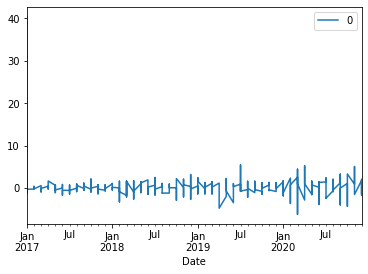

                 0
count  1006.000000
mean      0.090508
std       1.655711
min      -6.204212
25%      -0.357341
50%       0.092804
75%       0.539872
max      40.400501


In [43]:
residuals = pd.DataFrame(modfit.resid)
residuals.plot()
plt.show()
print(residuals.describe()) # más o menos valores cercanos al 0 ok

In [44]:
# Paso 2.b Predecimos con ARIMA
thres = 0.7
split_samples = int(len(close)*thres)
train, test = close[:split_samples],close[split_samples:]
print(train.shape,test.shape)

(704,) (302,)


In [47]:
import math
from sklearn.metrics import mean_squared_error

predictions = []
history = train.to_list()

for i,y in enumerate(test):
    model = sm.tsa.arima.ARIMA(endog=history, order=(3, 1, 0))
    modelfit = model.fit()
    ypred = modelfit.forecast()
    predictions.append(ypred)
    history.append(y)
    
    if i%20==0: # Cada 20 veces mostramos este mensaje
        print("%i\t Prediction: %.2f - Expected=%.2f"%(i,ypred,y))


rmse = math.sqrt(mean_squared_error(test,predictions))
print("RMSE: %.4f"%rmse)

0	 Prediction: 62.17 - Expected=62.21
20	 Prediction: 66.63 - Expected=65.99
40	 Prediction: 68.06 - Expected=67.74
60	 Prediction: 72.03 - Expected=72.51
80	 Prediction: 75.64 - Expected=75.94
100	 Prediction: 60.50 - Expected=53.65
120	 Prediction: 60.56 - Expected=63.26
140	 Prediction: 70.11 - Expected=68.76
160	 Prediction: 72.65 - Expected=73.24
180	 Prediction: 75.14 - Expected=75.93
200	 Prediction: 73.90 - Expected=75.25
220	 Prediction: 85.37 - Expected=81.48
240	 Prediction: 74.24 - Expected=72.78
260	 Prediction: 77.42 - Expected=80.81
280	 Prediction: 89.25 - Expected=87.72
300	 Prediction: 88.45 - Expected=87.89
RMSE: 1.5057


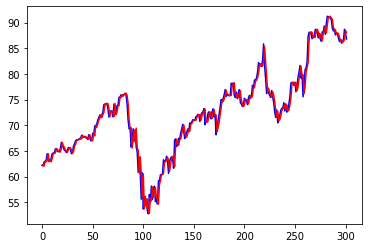

In [48]:
fig, ax = plt.subplots()
ax.plot(test.to_list(),color="b")
ax.plot(predictions,color="r")
plt.show()

### Reflexiones
- ¿Qué ocurre si el modelo no se entrena con cada nueva observación?
- ¿Qué ocurre si cambiamos de modelo ARIMA(1,0,0) o ARIMA(5,1,2)?
- ¿Qué ocurre si reducimos el threshold de entreno?
- ¿Qué ocurre si el periodo de la serie no es mensual?

## Predicción con un algoritmo supervisado

El objetivo de nuestro analisis será predecir el valor del cierre de MSFT en función del valor del cierre de IBM y GOOGLE y el uso de dos indices Dow Jones y S&P500

In [13]:
# Cargamos datos
stk_tickers = ['MSFT', 'IBM', 'GOOGL'] # Microsoft, IBM, Google
data = pdr.get_data_yahoo(stk_tickers, start="2017-01-01", end="2020-12-31")

data.to_csv("Stickers.csv")
idx_tickers = ['^GSPC', '^DJI'] # S&P 500 y Dow Jones index
idx_data = pdr.get_data_yahoo(idx_tickers, start="2017-01-01", end="2020-12-31")
idx_data.to_csv("idx_data.csv")

[                       0%%                      ]

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  2 of 2 completed


In [77]:
idx_data[:5]

Adj Close                      Close               \
                    ^DJI        ^GSPC          ^DJI        ^GSPC   
Date                                                               
2017-01-03  19881.759766  2257.830078  19881.759766  2257.830078   
2017-01-04  19942.160156  2270.750000  19942.160156  2270.750000   
2017-01-05  19899.289062  2269.000000  19899.289062  2269.000000   
2017-01-06  19963.800781  2276.979980  19963.800781  2276.979980   
2017-01-09  19887.380859  2268.899902  19887.380859  2268.899902   

                    High                        Low               \
                    ^DJI        ^GSPC          ^DJI        ^GSPC   
Date                                                               
2017-01-03  19938.529297  2263.879883  19775.929688  2245.129883   
2017-01-04  19956.140625  2272.820068  19878.830078  2261.600098   
2017-01-05  19948.599609  2271.500000  19811.119141  2260.449951   
2017-01-06  19999.630859  2282.100098  19834.080078  2264.060059   
2017-01-09  19943.779297  2275.489990  19887.380859  2268.899902   

                    Open                  Volume              
                    ^DJI        ^GSPC       ^DJI       ^GSPC  
Date                                                          
2017-01-03  19872.859375  2251.570068  339180000  3773010000  
2017-01-04  19890.939453  2261.600098  280010000  3768890000  
2017-01-05  19924.560547  2268.179932  269920000  3785080000  
2017-01-06  19906.960938  2271.139893  277700000  3342080000  
2017-01-09  19931.410156  2273.590088  287510000  3219730000

In [79]:
# Tomamos un periodo de 5 dias, de valores medios sobre los indices y cierres de  L - V.
# Primero, unimos lo datos en un DF
# print(type(data))
# print(type(idx_data))
# print(data.index)
# print(idx_data.index)
# Ambos son DF. Entonces es una operación de Merge
dataset = data.merge(idx_data, how="inner",left_index=True,right_index=True)
print(dataset[:5])

            Adj Close                             Close              \
                GOOGL         IBM       MSFT      GOOGL         IBM   
Date                                                                  
2017-01-03  40.400501  115.346283  57.138733  40.400501  159.837479   
2017-01-04  40.388500  116.774406  56.883060  40.388500  161.816437   
2017-01-05  40.651001  116.388031  56.883060  40.651001  161.281067   
2017-01-06  41.260502  116.960670  57.376125  41.260502  162.074570   
2017-01-09  41.359001  115.663643  57.193516  41.359001  160.277252   

                            High                               Low  ...  \
                 MSFT      GOOGL         IBM       MSFT      GOOGL  ...   
Date                                                                ...   
2017-01-03  62.580002  40.571999  160.487579  62.840000  39.844501  ...   
2017-01-04  62.299999  40.671501  162.399612  62.750000  40.205502  ...   
2017-01-05  62.299999  40.687000  161.940720  62.660000 

### Reconvertimos las series a una frecuencia de 5 días laborales

In [86]:
# Reconvertimos la frecuencia agrupando los valores.
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
data5days = dataset.resample("1W-MON").mean()  # averaging all values along 5 days starting on Mondays 
data5days.head()


Adj Close                             Close              \
                GOOGL         IBM       MSFT      GOOGL         IBM   
Date                                                                  
2017-01-09  40.811901  116.226607  57.094899  40.811901  161.057361   
2017-01-16  41.454250  115.311789  57.321336  41.454250  159.789677   
2017-01-23  41.534500  116.330086  57.162466  41.534500  161.200766   
2017-01-30  42.338200  122.245378  58.869874  42.338200  169.397702   
2017-02-06  40.954400  120.744156  58.201518  40.954400  167.317398   

                            High                               Low  ...  \
                 MSFT      GOOGL         IBM       MSFT      GOOGL  ...   
Date                                                                ...   
2017-01-09  62.532000  40.980000  161.921606  62.896001  40.400401  ...   
2017-01-16  62.780000  41.554250  160.693115  63.142500  41.189251  ...   
2017-01-23  62.606000  41.677701  161.780115  62.864000  41.245400  ...   
2017-01-30  64.475999  42.755399  170.248566  64.816001  42.054700  ...   
2017-02-06  63.744000  41.201500  167.986615  64.106001  40.713400  ...   

                   Close                       High               \
                    ^DJI        ^GSPC          ^DJI        ^GSPC   
Date                                                               
2017-01-09  19914.878125  2268.691992  19957.335938  2273.158008   
2017-01-16  19896.634766  2272.324951  19952.964355  2276.262512   
2017-01-23  19798.198047  2267.995947  19842.650000  2273.432031   
2017-01-30  20029.408203  2290.141992  20060.282031  2294.039990   
2017-02-06  19952.764062  2285.850049  19997.016016  2289.337988   

                     Low                       Open                    Volume  \
                    ^DJI        ^GSPC          ^DJI        ^GSPC         ^DJI   
Date                                                                            
2017-01-09  19837.467969  2260.027979  19905.346094  2265.216016  290864000.0   
2017-01-16  19822.260254  2262.965027  19900.620117  2270.549988  301407500.0   
2017-01-23  19736.757812  2261.320020  19814.990234  2269.583936  337072000.0   
2017-01-30  19958.350391  2281.860010  19999.477734  2288.083936  352768000.0   
2017-02-06  19885.774219  2277.549951  19937.026172  2283.824023  354716000.0   

                          
                   ^GSPC  
Date                      
2017-01-09  3.577758e+09  
2017-01-16  3.455635e+09  
2017-01-23  3.353020e+09  
2017-01-30  3.602052e+09  
2017-02-06  3.707408e+09  

[5 rows x 30 columns]

In [87]:
# Limpiamos series innecesarias
for ix,col in enumerate(data5days.columns):
    print(ix,col)
    

0 ('Adj Close', 'GOOGL')
1 ('Adj Close', 'IBM')
2 ('Adj Close', 'MSFT')
3 ('Close', 'GOOGL')
4 ('Close', 'IBM')
5 ('Close', 'MSFT')
6 ('High', 'GOOGL')
7 ('High', 'IBM')
8 ('High', 'MSFT')
9 ('Low', 'GOOGL')
10 ('Low', 'IBM')
11 ('Low', 'MSFT')
12 ('Open', 'GOOGL')
13 ('Open', 'IBM')
14 ('Open', 'MSFT')
15 ('Volume', 'GOOGL')
16 ('Volume', 'IBM')
17 ('Volume', 'MSFT')
18 ('Adj Close', '^DJI')
19 ('Adj Close', '^GSPC')
20 ('Close', '^DJI')
21 ('Close', '^GSPC')
22 ('High', '^DJI')
23 ('High', '^GSPC')
24 ('Low', '^DJI')
25 ('Low', '^GSPC')
26 ('Open', '^DJI')
27 ('Open', '^GSPC')
28 ('Volume', '^DJI')
29 ('Volume', '^GSPC')


In [95]:
columns_si = [3,4,5,15,16,17,20,21]
columns_to_remove = set(range(len(data5days.columns)))-set(columns_si)
columns_to_remove = list(columns_to_remove)
columns_to_remove

[0,
 1,
 2,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 18,
 19,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [96]:
data5days = data5days.drop(data5days.columns[columns_to_remove],axis=1)
data5days.head()

Close                             Volume             \
                GOOGL         IBM       MSFT       GOOGL        IBM   
Date                                                                  
2017-01-09  40.811901  161.057361  62.532000  32963200.0  3165907.2   
2017-01-16  41.454250  159.789677  62.780000  25812500.0  3535767.5   
2017-01-23  41.534500  161.200766  62.606000  29210800.0  6789606.8   
2017-01-30  42.338200  169.397702  64.475999  56426000.0  4919526.2   
2017-02-06  40.954400  167.317398  63.744000  35357600.0  3245800.8   

                               Close               
                  MSFT          ^DJI        ^GSPC  
Date                                               
2017-01-09  21443140.0  19914.878125  2268.691992  
2017-01-16  20125200.0  19896.634766  2272.324951  
2017-01-23  22419380.0  19798.198047  2267.995947  
2017-01-30  33673920.0  20029.408203  2290.141992  
2017-02-06  32173440.0  19952.764062  2285.850049

In [99]:
# Facilitamosel manejo de columnas, eliminando un nivel superior (son : close o volume)
data5days.columns = data5days.columns.droplevel(0)
data5days.columns

Index(['GOOGL', 'IBM', 'MSFT', 'GOOGL', 'IBM', 'MSFT', '^DJI', '^GSPC'], dtype='object')

In [100]:
# Y renombramos columnas: MUY IMPORTANTE EL ORDEN!!
columns_names = ["CloseGOOGL","CloseIBM","CloseMSFT","VolGOOGL","VolIBM","VolMSFT","DJI","SP500"]
data5days.columns = columns_names

data5days.head()


,CloseGOOGL,CloseIBM,CloseMSFT,VolGOOGL,VolIBM,VolMSFT,DJI,SP500
Date,,,,,,,,
2017-01-09,40.811901,161.057361,62.532000,32963200.0,3165907.2,21443140.0,19914.878125,2268.691992
2017-01-16,41.454250,159.789677,62.780000,25812500.0,3535767.5,20125200.0,19896.634766,2272.324951
2017-01-23,41.534500,161.200766,62.606000,29210800.0,6789606.8,22419380.0,19798.198047,2267.995947
2017-01-30,42.338200,169.397702,64.475999,56426000.0,4919526.2,33673920.0,20029.408203,2290.141992
2017-02-06,40.954400,167.317398,63.744000,35357600.0,3245800.8,32173440.0,19952.764062,2285.850049


Con los datos preparados, podemos analizar los valores de estas series y sus posibles relaciones

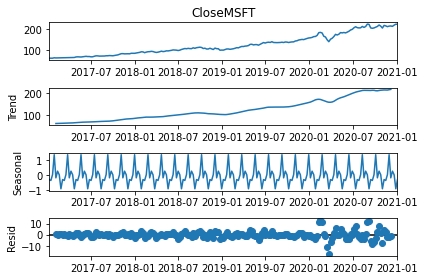

In [102]:
# Su desomposición
res = sm.tsa.seasonal_decompose(data5days.CloseMSFT,period=8) # que implica este 8?
fig = res.plot()
plt.show()

o incluso podemos mirar la matriz de correlación para detectar algún patrón común entre los datos

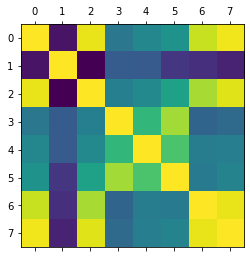

In [103]:
#con matplotlib 
import matplotlib.pyplot as plt
correlation = data5days.corr()
plt.matshow(correlation)

<AxesSubplot:>

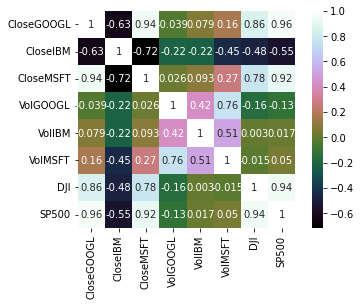

In [104]:
#con seaborn 
import seaborn as sns
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Con los datos preparados podemos aplicar modelos supervisados de predicción

Nuestra variable objetivo será el valor de cierre de MSFT

In [107]:
# Aplicación de modelos de supervisado

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Vamos aplicar diferentes modelos al mismo tiempo!
models = [LinearRegression,SVR,RandomForestRegressor]

# Preparamos las variables: features y target
X = data5days.drop(labels=["CloseMSFT"],axis=1)
Y = data5days.CloseMSFT

# Particionamos los datos de entreno y test al 80%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=33)


In [108]:
# Variables de salida
model_names = []
train_results = []
test_results = []

# Entrenamos y testeamos
for model in models:
    print("Model: %s"%model.__name__)
    model_names.append(model.__name__)
    res = model().fit(X=X_train,y=y_train)
    train_result = mean_squared_error(res.predict(X_train), y_train) 
    train_results.append(train_result)

    test_result = mean_squared_error(res.predict(X_test), y_test)
    test_results.append(test_result)


Model: LinearRegression
Model: SVR
Model: RandomForestRegressor


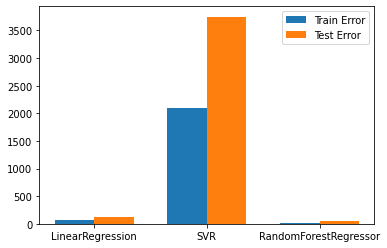

In [109]:
import numpy as np
ind = np.arange(len(models)) 
width = 0.35 # the width of the bars

fig,ax = plt.subplots()
plt.bar(ind - width/2, train_results, width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(model_names)
plt.show()

## Más allá de la regresión lineal simple

En la sesión de hoy seguiremos trabajando con las técnicas de regresión, profundizaremos
en las técnicas de regresión lineal y veremos otras técnicas de regresión no lineal.
Por otra parte revisaremos las métricas más usadas para este problema. Finalmente
trabajaremos en la automatización de los procesos de aprendizaje automático.

1. Uso de la regularización
2. Regresión no lineal: un ejemplo
3. Métricas de regresión
4. Buenas prácticas I: Conjuntos de entrenamiento y test.


### 1. Uso de la regularización

Una forma de encontrar una buena relación entre el sesgo y la varianza es ajustar la complejidad del modelo a través de
**la regularización**. La regularización es un método muy útil para manejar
colinealidad (alta correlación entre características), filtrar el ruido de los datos y
eventualmente evitará el _overfitting_. El concepto detrás de la regularización es introducir
información adicional (sesgo) para penalizar los valores extremas de los parámetros.

Si tenemos que la expresión para una regresión lineal es: $$y = w_0x_0+w_1x_1+...+w_nx_n=\sum^m_{i=0} w_i X_{i}$$

Y la función que queremos minimizar es: $$J(w) = \sum^n_{i=1}(y^{(i)}-\hat{y}^{(i)})^2 $$


### Ridge Regression
La _Ridge Regression_ es un modelo que usa una penalización aplicando la norma L2 donde simplemente agregamos
la suma al cuadrado de los pesos de nuestra función de coste:

$$ J(w)_{Ridge} = \sum^n_{i=1}(y^{(i)}-\hat{y}^{(i)})^2 + \lambda\| w \|_2$$

El uso de esta regresión sería el siguiente:

In [110]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)

Al aumentar el valor del hiperparámetro $\lambda$, aumentamos la fuerza de la regularización
y encogemos los pesos de nuestro modelo. Hay que tener en cuenta que no regularizamos
el término del _intercepto_ ($w_0$).

### Lasso Regression (L1)
Un enfoque alternativo que puede conducir a modelos dispersos es la regresión LASSO.
Según sea el valor del término de regularización, ciertos pesos pueden coger el valor cero,
lo que hace que este tipo de regresión LASSO también sea útil como técnica de selección de características
supervisada.

La función a minimizar en este caso es:
$$ J(w)_{Lasso} = \sum^n_{i=1}(y^{(i)}-\hat{y}^{(i)})^2 + \lambda\| w \|_1$$

El uso de esta regresión sería el siguiente:

In [111]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

### Elastic Net Regression

Sin embargo, una limitación de LASSO es que selecciona como máximo $n$ variables si $ m > n $.
_Elastic Net_ ofrece un buen compromiso entre la _Ridge_ _regression_  y LASSO, que tiene una
Penalización L1 para generar una selección de características y penalización L2 para superar algunas de las limitaciones de la regresión LASSO, como es el número de variables seleccionadas.

La función a minimizar en este caso es:

$$ J(w)_{Elasticnet} = \sum^n_{i=1}(y^{(i)}-\hat{y}^{(i)})^2 + \lambda_1 \sum^n_{i=1} w^2_j + \lambda_2 \sum^n_{i=1} w_j $$

El uso de esta regresión sería el siguiente:

In [112]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=1.0, l1_ratio=0.5)

### Regresión polinómica
La regresión polinomial es un caso especial de regresión lineal en el que se construyen nuevas características en
función del grado del polinomio que se quiera construir.
En las secciones anteriores, hemos asumido una relación lineal entre las variables del modelo y
la variable objetivo. Una forma de no tener en cuenta el supuesto de linealidad es
usar un modelo de regresión polinomial, es decir agregando términos polinomiales.

$$ y = w_0 + w_1x + w_2x^2 + ... + w_dx^d $$

donde $d$ es el grado del polinomio. Aunque podemos usar un polinomio
para modelar una relación no lineal, todavía se considera una
modelo de regresión lineal debido a los coeficientes $w$.


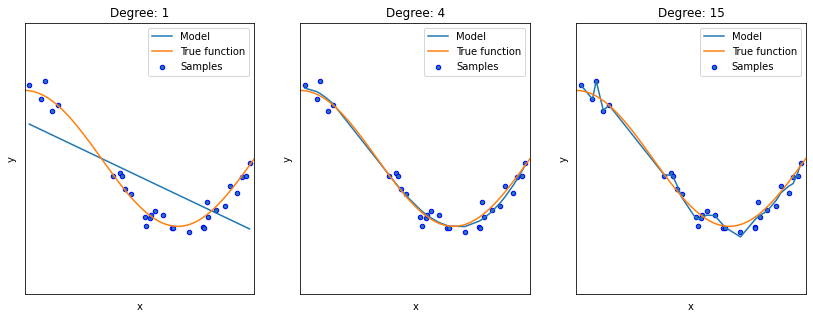

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))

for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    
    linear_regression = LinearRegression()
    polynomial_features = PolynomialFeatures(degree=degrees[i])
    polynomial = polynomial_features.fit_transform(X[:, np.newaxis])
    
    linear_regression.fit(polynomial, y)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X, linear_regression.predict(polynomial), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")

    plt.title( "Degree: " + str(degrees[i]))
    
plt.show()

### Regresión no lineal: un ejemplo

Cuando queremos resolver un problema usando un modelo más complejo podemos elegir alguno de los siguientes:

- Árboles de regresión
- Bosques de regresión
- SVM para la regresión
- Y todos los modelos que existen...

Realizaremos un ejercicio con los árboles de decisión debido a que son fáciles de entender y que en sesiones futuras
trabajaremos con los análogos de los Bosques de regresión y las SVM para problemas de clasificación.

Los **árboles de decisión (DT)** son un método de aprendizaje supervisado no paramétrico que se utiliza para
clasificación y regresión. El objetivo es crear un modelo que prediga el valor de una variable objetivo mediante
el aprendizaje de reglas de decisión simples inferidas de las características de los datos. Un árbol puede verse como
una aproximación de una función a trozos.

En sci-kit la clase que modela este tipo de árboles se llama `DecisionTreeRegressor` [enlace](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html)

Veamos un ejemplo sencillo:

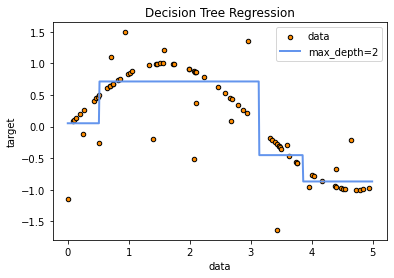

In [114]:
# Importamos las librerias necesarias
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Generamos un conjunto de datos (función seno)
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Entrenamos el modelo

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_1.fit(X, y)

# Realizamos una predicción
X_test = np.expand_dims(np.arange(0.0, 5.0, 0.01), 1)
y_1 = regr_1.predict(X_test)

# Mostramos los resultados
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Vamos a ver la estructura del primer árbol que hemos entrenado para entender mejor el proceso que ha seguido:

[Text(0.5, 0.8333333333333334, 'X[0] <= 3.133\nsquared_error = 0.547\nsamples = 80\nvalue = 0.122'),
 Text(0.25, 0.5, 'X[0] <= 0.514\nsquared_error = 0.231\nsamples = 51\nvalue = 0.571'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.192\nsamples = 11\nvalue = 0.052'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.148\nsamples = 40\nvalue = 0.714'),
 Text(0.75, 0.5, 'X[0] <= 3.85\nsquared_error = 0.124\nsamples = 29\nvalue = -0.667'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.124\nsamples = 14\nvalue = -0.452'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.041\nsamples = 15\nvalue = -0.869')]

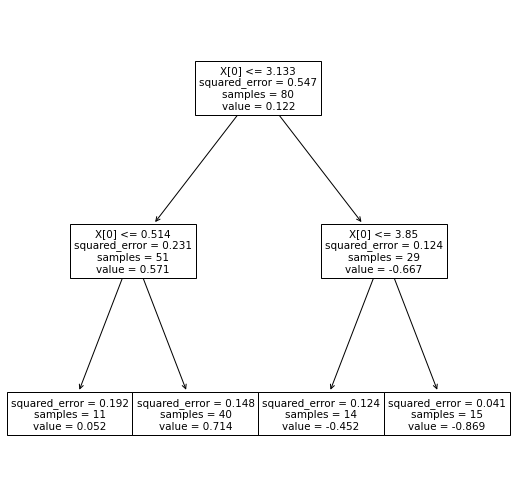

In [115]:
from sklearn import tree
plt.figure(figsize=(9,9))
tree.plot_tree(regr_1)

**Ejercicio**

- Cambia el parámetro _max_depth_ del modelo. Que pasa si es 1? Que pasa si es 5 o mayor?
- Visualiza el árbol resultante. 
- Cuál es la medida de Score de este método (mirar documentación)? Como cambia al permitir árboles más profundos?
- Busca en la documentación de Sci-kit de los Bosques de Regresión ( _RandomForestRegressor_ ) compara el score obtenido cuando incrementamos el número de árboles, manteniendo la misma profundidad.

## Métricas para problemas de regression

Las métricas más comunes en los problemas de regresión son el **error cuadrático** y el **error absoluto**, y sus distintas modificaciones.

### 3.1 Errores cuadráticos

El **error cuadrático (Squared Error)** de un valor predicho con respecto al valor real, se calcula cómo:

$$ SE = \sum_j\left[\hat{y}_j - y_j\right]^2$$


**Error cuadrático medio (Mean Squared Error)** Da una idea del error de nuestras predicciones dando más peso a los errores grandes.

$$ MSE = \frac{1}{m}\sum_j^m \left[\hat{y}_j - y_j\right]^2 $$

**Raiz del error cuadrático medio (Root Mean Square Error)** La raíz cuadrada del MSE produce el error de la raíz cuadrada de la media o la desviación de la raíz cuadrada media (RMSE o RMSD). Tiene las mismas unidades que la cantidad que estima. Para un estimador sin sesgo (bies), el RMSE es la raíz cuadrada de la varianza, es decir la desviación estandar.

$$ RMSE = \sqrt{\frac{1}{m}\sum_j^m \left[\hat{y}_j - y_j\right]^2} $$



A pesar de ser una de las métricas más utilizadas, tiene el inconveniente de ser sensible a los valores extremos (outliers). Cuando este comportamiento pueda suponer un problema, los **errores absolutos** pueden darnos una mejor medida de rendimiento.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
sns.set_context('notebook')
sns.set(rc={'figure.figsize':(12, 8)})

In [34]:
## Escribe una función que devuelva el MSE y el RMSE dados dos arrays de numpy

def MSE(x1, x2):
    """
    Returns the Root Mean Squared Error of the two input vectors
    """
    sq_error = ##
    mean_sq_error = np.##
    return mean_sq_error

def RMSE(x1, x2):
    """
    Returns the Root Mean Squared Error of two vectors. Depends on the MSE function
    """
    mse = MSE(x1, x2)
    root_mse = np.##
    return root_mse

SyntaxError: invalid syntax (820556737.py, line 7)

### 3.2 Errores absolutos

El **error absoluto** (Absolute Error) se define cómo:

$$ AE = \sum_j \left|\hat{y}_j - y_j\right| $$

#### Error absoluto medio (Mean Absolute Error)

Es más robusto a los valores extremos y su interpretabilidad es más alta que la del RMSE ya que también está en las unidades de la variable a predecir con la ventaja de que el dato no ha sufrido ninguna transformación.

$$ MAE = \frac{1}{m} \sum_j^m \left|\hat{y}_j - y_j\right| $$

#### Error absoluto medio porcentual (Mean Average Percentage Error)

A pesar de su simpleza, presenta varios inconvenientes a la hora de usarlo de forma práctica. Por ejemplo, **no puede usarse cuando el valor de referencia es 0**. Además, **si se usa para elegir métodos predictivos seleccionará de forma sistemática un metodo que prediga valores bajos.**
[wiki](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

$$ MAPE = \frac{1}{m} \sum_j^m \left|\frac{\hat{y}_j - y_j}{y_j}\right| $$

### 3.3 Generalización

Las dos **métricas** expuestas anteriormente pueden considerarse como **distancias entre el vector de valores reales y el predicho**. De hecho, el RMSE corresponde a la **distancia euclidiana**, también conocida como norma $l_2$ o $\lVert{v}\rVert_2$.

Por otro lado, el MAE corresponde a la norma $l_1$ o $\lVert{v}\rVert_1$. A esta distancia se la conoce como **distancia de manhattan**, porque sólo se puede viajar de un bloque a otro de la ciudad a traves de calles ortogonales.

De forma general, una norma $l_k$ o $\lVert{v}\rVert_k$ se calcula:

$$\lVert{v}\rVert_k = \left(|v_0|^k + ...+ |v_m|^k \right)^\frac{1}{k}$$

El concepto de distancia será particularmente útil en los problemas de segmentación (aprendizaje no supervisado)


### 3.4 Coeficiente de determinación ($R^2$)

El coeficiente determina la calidad del modelo para replicar los resultados, y la proporción de variación de los resultados que puede explicarse por el modelo. El valor más alto obtenible será 1, aunque hay casos en los que puede presentar valores negativos. De forma intuitiva, $R^2$ compara el "fit" de nuestro modelo al de una linea recta horizontal. Dada una regresión lineal simple, un $R^2$ negativo sólo es posible cuando la ordenada en el origen o la pendiente están restringidas de forma que el mejor modelo es peor que una linea horizontal.

Si representamos la **varianza de la variable dependiente** por $\sigma^{2}$ y la **varianza residual** por $\sigma _{r}^{2}$, el coeficiente de determinación viene dado por la siguiente ecuación:

$$ R^{2}=1- \frac{\sigma_{r}^{2}}{\sigma ^{2}}$$


Siendo $\hat{y}_i$ el valor predicho de la muestra i y $y_i$ el valor real, el $R^2$ estimado sobre $n_{\text{muestras}}$ se define como:

$$ R^2(y, \hat{y}) = 1 - \frac{\sum_{i=0}^{n_{\text{samples}} - 1} (y_i - \hat{y}_i)^2}{\sum_{i=0}^{n_\text{samples} - 1} (y_i - \bar{y})^2}$$
donde $$ \bar{y} =  \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}} - 1} y_i$$

#### 3.4.1 Consideraciones R²

1. R² no puede determinar si los coeficientes y las predicciones tienen bies: Hay que checkear los residos --> Si observamos patrones en los plots de residuos es indicativo de un mal ajuste a pesar de un R2 elevado

1. Cada vez que añadimos un predictor a un modelo, el R² aumenta aunque sea por suerte, pero nunca decrece. Por consiguiente, un modelo con muchos terminos puede parecer mejor simplemente por el hecho de tener más terminos. Para prevenir este efecto, podemos usar el **adjusted R²**, una versión modificada que se ajusta al número de predictores en el modelo. De ésta forma, el R² solo aumenta si el nuevo término mejora el modelo más que por mera suerte. Siempre es más bajo que el R²

$$\bar{R}^2 = 1 - \frac{N-1}{N-k-1}(1-R^2)$$


n – numero de observaciones

k – numero de parametros

[![License: CC BY 4.0](https://img.shields.io/badge/License-CC_BY_4.0-lightgrey.svg)](https://creativecommons.org/licenses/by/4.0/) <br/>
Isaac Lera and Gabriel Moya <br/>
Universitat de les Illes Balears <br/>
isaac.lera@uib.edu, gabriel.moya@uib.edu